In [2]:
import os
from PIL import Image
from collections import Counter
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
from skimage.io import imread
import cv2
import glob


In [3]:
# finding image paths 
img_path = "../../Data/padchest_sample2/"
all_files = list(glob.glob(img_path+'*.png'))
all_files = [str(path)[28:] for path in all_files]
print(len(all_files))
print(all_files[0])

137
224904318374059042978778904037988750967_dbs3bj.png


In [4]:
def getDenseMask(RL, LL, H = None, RCLA = None, LCLA = None, imagesize = 1024):
    img = np.zeros([1024,1024])
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 2, -1)
    
    if RCLA is not None:
        RCLA = RCLA.reshape(-1, 1, 2).astype('int')
        img = cv2.drawContours(img, [RCLA], -1, 4, -1)
    
    if LCLA is not None:      
        LCLA = LCLA.reshape(-1, 1, 2).astype('int')  
        img = cv2.drawContours(img, [LCLA], -1, 5, -1)

    return img#.resize((512,512))

### Loading in the true masks from Padchest 

In [6]:
di = "../../Data/Chest-xray-landmark-dataset-main/"
true_masks = [] 

for i in all_files:
    img_path = di + "Images/" + i
    RL = img_path.replace('Images','landmarks/RL').replace('.png','.npy')
    LL = img_path.replace('Images','landmarks/LL').replace('.png','.npy')

    RL = np.load(RL)
    LL = np.load(LL)

    mask = getDenseMask(RL,LL)
    mask = np.array(Image.fromarray(mask).resize((512,512)))
    mask = np.where(mask!=0, 1, 0)
    
    true_masks.append(mask)

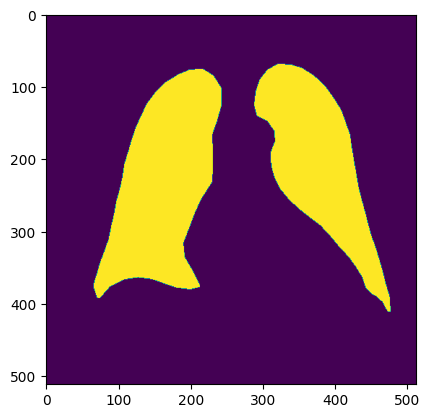

In [7]:
plt.imshow(true_masks[0])
plt.show()

### Getting our predicted masks 

In [8]:
data = pd.read_csv("../Data/preprocessed_df_08032023.csv", index_col=0)

/tmp/ipykernel_4044603/2470532100.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/preprocessed_df_08032023.csv", index_col=0)


In [9]:
mapping_dict = {data["ImageID"][idx]: data["ImageDir"][idx] for idx in range(len(data))}

In [10]:
print(all_files[0])
print(mapping_dict[all_files[0]])

224904318374059042978778904037988750967_dbs3bj.png
0


In [11]:
di= "../../Data/padchest-preprocessed/" 
print(di+str(mapping_dict[all_files[0]])+"/"+all_files[0])
img_array_training = np.stack([np.array(Image.open(di+str(mapping_dict[path])+"/"+path)) for path in all_files], 0)
img_array_training = np.expand_dims(np.asarray(img_array_training, dtype = np.float), axis = 3)

../../Data/padchest-preprocessed/0/224904318374059042978778904037988750967_dbs3bj.png


/tmp/ipykernel_4044603/427636343.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_array_training = np.expand_dims(np.asarray(img_array_training, dtype = np.float), axis = 3)


<function matplotlib.pyplot.show(close=None, block=None)>

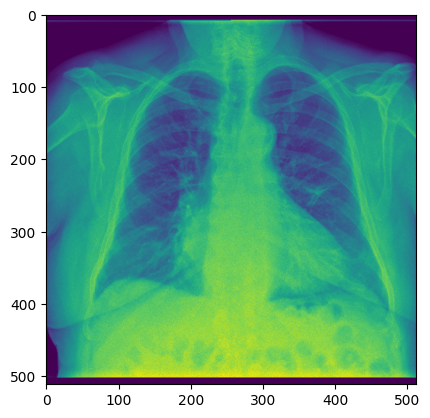

In [12]:
plt.imshow(img_array_training[0,:,:,0])
plt.show

In [13]:
model = load_model('Unet_allds_200epochs.hdf5')

<function matplotlib.pyplot.show(close=None, block=None)>

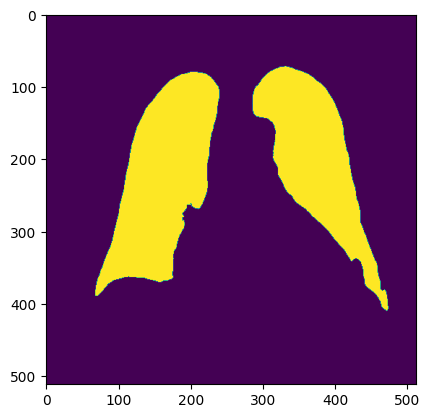

In [24]:
all_results = model.predict(np.expand_dims(np.asarray(img_array_training), axis=3))
all_results.shape
plt.imshow(all_results[0,:,:,0])
plt.show

### Compute Dice Score 

In [18]:
def compute_dice(prediction, target):
    dice = np.sum(prediction[target > 0]) * 2.0 / (np.sum(prediction) + np.sum(target))
    return dice

In [19]:
true_mask_np = np.stack([i for i in true_masks], 0)


In [20]:
print(all_results.shape)
print(true_mask_np.shape)

(137, 512, 512, 1)
(137, 512, 512)


In [23]:
dice_scores = []
for pred, y_hat in zip(all_results[:, :, :, 0], true_mask_np):
    dice_scores.append(compute_dice(pred > 0.5, y_hat > 0))
    
print(f"average dice score for {len(dice_scores)} test images is: {sum(dice_scores) / len(dice_scores):.4f}")

average dice score for 137 test images is: 0.9287
